In [ ]:
# Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 프로젝트 루트 설정
PROJECT_ROOT = "/content/drive/MyDrive/loid_cityscapes"

import os
print(f"✅ Project root: {PROJECT_ROOT}")
print(f"✅ Working directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Project root: /content/drive/MyDrive/loid_cityscapes
✅ Working directory: /content


In [ ]:
!pip install torch torchvision torchaudio

# 필수 패키지 설치
!pip install -q numpy
!pip install -q ultralytics
!pip install -q simple-lama-inpainting
!pip install -q segmentation-models-pytorch
!pip install -q opencv-python
!pip install -q albumentations
!pip install -q matplotlib
!pip install -q pandas
!pip install -q pyyaml

print("✅ 패키지 설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

import segmentation_models_pytorch as smp
from ultralytics import YOLO
from simple_lama_inpainting import SimpleLama

# 버전 확인
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ CUDA not available, using CPU")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {DEVICE}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ PyTorch: 2.9.0+cu126
✅ CUDA Available: True
✅ GPU: Tesla T4
✅ Device: cuda


In [ ]:
import os
import glob

DATA_ROOT = f"{PROJECT_ROOT}/datasets"

print(f"📁 DATA_ROOT: {DATA_ROOT}")

# 폴더 구조 확인
print(f"\n📁 데이터 폴더 구조:")
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        sub_indent = " " * 2 * (level + 1)
        for file in files[:3]:
            print(f"{sub_indent}{file}")
        if len(files) > 3:
            print(f"{sub_indent}... and {len(files)-3} more files")

# 이미지 개수 확인
train_imgs = glob.glob(f"{DATA_ROOT}/leftImg8bit/train/**/*.png", recursive=True)
val_imgs = glob.glob(f"{DATA_ROOT}/leftImg8bit/val/**/*.png", recursive=True)

print(f"\n📊 데이터 개수:")
print(f"  Train: {len(train_imgs)}장")
print(f"  Val:   {len(val_imgs)}장")

if len(train_imgs) > 0 and len(val_imgs) > 0:
    print("\n✅ Cityscapes 준비 완료! (공유폴더에서 직접 사용 중)")
else:
    print("\n❌ 이미지를 찾을 수 없습니다. 경로/폴더명을 다시 확인하세요.")


📁 DATA_ROOT: /content/drive/MyDrive/loid_cityscapes/datasets

📁 데이터 폴더 구조:
datasets/
  README
  license.txt
  gtFine/
    val/
      munster/
      lindau/
      frankfurt/
    test/
      bonn/
      berlin/
      leverkusen/
      munich/
      mainz/
      bielefeld/
    train/
      cologne/
      tubingen/
      zurich/
      erfurt/
      weimar/
      aachen/
      darmstadt/
      bremen/
      bochum/
      strasbourg/
      monchengladbach/
      krefeld/
      hanover/
      hamburg/
      jena/
      stuttgart/
      ulm/
      dusseldorf/
  leftImg8bit/
    train/
      stuttgart/
      ulm/
      cologne/
      tubingen/
      zurich/
      erfurt/
      jena/
      weimar/
      dusseldorf/
      aachen/
      darmstadt/
      bremen/
      bochum/
      strasbourg/
      monchengladbach/
      krefeld/
      hanover/
      hamburg/
    val/
      munster/
      lindau/
      frankfurt/
    test/
      bonn/
      berlin/
      leverkusen/
      munich/
      mainz/
    

In [ ]:
# Cityscapes 도로 관련 클래스 ID
CITYSCAPES_ROAD_IDS = {7, 8, 9, 10}  # road, sidewalk, parking, rail track

# 클래스 이름
CLASS_NAMES = {
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track"
}

print("🚗 Cityscapes 도로 관련 클래스:")
for class_id, class_name in CLASS_NAMES.items():
    print(f"  ID {class_id}: {class_name}")

print(f"\n✅ 사용할 클래스: {CITYSCAPES_ROAD_IDS}")
print("→ Binary lane/road proxy GT 생성")


🚗 Cityscapes 도로 관련 클래스:
  ID 7: road
  ID 8: sidewalk
  ID 9: parking
  ID 10: rail track

✅ 사용할 클래스: {8, 9, 10, 7}
→ Binary lane/road proxy GT 생성


In [ ]:
# 🔍 문제 진단 코드
import os
import glob

DATA_ROOT = "/content/drive/MyDrive/loid_cityscapes/datasets"

# 1. 폴더 구조 확인
print("📁 폴더 구조:")
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, '').count(os.sep)
    if level <= 1:
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        if files:
            print(f'{indent}  파일 예시: {files[0]}')

# 2. 이미지 파일 예시
img_path = glob.glob(f"{DATA_ROOT}/leftImg8bit/train/aachen/*_leftImg8bit.png")[0]
print(f"\n✅ 이미지 예시: {img_path}")

# 3. GT 파일 예상 경로
gt_expected = img_path.replace("leftImg8bit", "gtFine").replace("_leftImg8bit.png", "_gtFine_labelIds.png")
print(f"🔍 GT 예상: {gt_expected}")
print(f"✅ GT 존재: {os.path.exists(gt_expected)}")

# 4. 실제 GT 파일 목록
gt_dir = os.path.dirname(gt_expected)
gt_files = [f for f in os.listdir(gt_dir) if f.endswith("_labelIds.png")]
print(f"\n📋 GT 파일 예시 (처음 3개): {gt_files[:3]}")


📁 폴더 구조:
datasets/
  파일 예시: README
  gtFine/
  leftImg8bit/

✅ 이미지 예시: /content/drive/MyDrive/loid_cityscapes/datasets/leftImg8bit/train/aachen/aachen_000029_000019_leftImg8bit.png
🔍 GT 예상: /content/drive/MyDrive/loid_cityscapes/datasets/gtFine/train/aachen/aachen_000029_000019_gtFine.png
✅ GT 존재: False

📋 GT 파일 예시 (처음 3개): ['aachen_000002_000019_gtFine_labelIds.png', 'aachen_000003_000019_gtFine_labelIds.png', 'aachen_000000_000019_gtFine_labelIds.png']


In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
import glob
import os
from PIL import Image

class CityscapesLaneDataset(Dataset):
    """Cityscapes 도로/차선 세그멘테이션 데이터셋"""

    def __init__(self, root, split="train", transform=None):
        self.root = root
        self.split = split
        self.transform = transform

        # 이미지/라벨 경로
        img_dir = os.path.join(root, "leftImg8bit", split)
        gt_dir = os.path.join(root, "gtFine", split)

        # 파일 찾기
        all_img_paths = sorted(glob.glob(f"{img_dir}/*/*.png"))
        all_gt_paths = sorted(glob.glob(f"{gt_dir}/*/*_gtFine_labelIds.png"))

        print(f"🔍 총 이미지: {len(all_img_paths)}장")
        print(f"🔍 총 GT: {len(all_gt_paths)}장")

        # 파일명 매칭
        self.img_paths = []
        self.gt_paths = []

        img_basenames = {os.path.basename(p) for p in all_img_paths}
        gt_basenames = {os.path.basename(p) for p in all_gt_paths}

        matched_count = 0
        for img_path in all_img_paths:
            img_name = os.path.basename(img_path)
            gt_name = img_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")

            if gt_name in gt_basenames:
                city_folder = os.path.basename(os.path.dirname(img_path))
                gt_path = os.path.join(gt_dir, city_folder, gt_name)
                self.img_paths.append(img_path)
                self.gt_paths.append(gt_path)
                matched_count += 1

        print(f"✅ 매칭된 쌍: {matched_count}개")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # 안전한 PIL → numpy 변환
        img_pil = Image.open(self.img_paths[idx]).convert("RGB")
        img = np.asarray(img_pil).astype(np.float32) / 255.0  # [H,W,C] 0~1

        labelids_pil = Image.open(self.gt_paths[idx])
        labelids = np.asarray(labelids_pil).astype(np.uint8)  # [H,W]

        # Road proxy GT 생성
        lane_gt = np.isin(labelids, list(CITYSCAPES_ROAD_IDS)).astype(np.float32)

        # 변환 적용
        if self.transform:
            augmented = self.transform(image=(img * 255).astype(np.uint8), mask=(lane_gt * 255).astype(np.uint8))
            img = augmented['image'].astype(np.float32) / 255.0
            lane_gt = augmented['mask'].astype(np.float32) / 255.0

        # 텐서 변환 (torch.tensor 사용)
        img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)  # [C,H,W]
        gt_tensor = torch.tensor(lane_gt, dtype=torch.float32)  # [H,W]

        return {
            "image": img_tensor,
            "lane_gt": gt_tensor,
            "img_path": self.img_paths[idx]
        }

# 테스트 실행
print("\n🔍 데이터셋 로드 중...")
train_dataset = CityscapesLaneDataset(DATA_ROOT, split="train")
val_dataset = CityscapesLaneDataset(DATA_ROOT, split="val")

# 샘플 확인
sample = train_dataset[0]
print(f"\n✅ 샘플 로드 성공!")
print(f"   Image: {os.path.basename(sample['img_path'])}")
print(f"   Image shape: {sample['image'].shape}")
print(f"   Image dtype: {sample['image'].dtype}")
print(f"   Image range: [{sample['image'].min():.3f}, {sample['image'].max():.3f}]")
print(f"   GT shape: {sample['lane_gt'].shape}")
print(f"   GT dtype: {sample['lane_gt'].dtype}")
print(f"   GT range: [{sample['lane_gt'].min():.3f}, {sample['lane_gt'].max():.3f}]")



🔍 데이터셋 로드 중...
🔍 총 이미지: 2975장
🔍 총 GT: 2975장
✅ 매칭된 쌍: 2975개
🔍 총 이미지: 500장
🔍 총 GT: 500장
✅ 매칭된 쌍: 500개

✅ 샘플 로드 성공!
   Image: aachen_000000_000019_leftImg8bit.png
   Image shape: torch.Size([3, 1024, 2048])
   Image dtype: torch.float32
   Image range: [0.000, 1.000]
   GT shape: torch.Size([1024, 2048])
   GT dtype: torch.float32
   GT range: [0.000, 1.000]


In [ ]:
class LaneSegmentationModel(nn.Module):
    """DeepLabV3+ 기반 차선/도로 세그멘테이션 모델"""

    def __init__(self, num_classes=1, encoder="resnet34"):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            classes=num_classes,
            activation=None  # BCEWithLogitsLoss에서 activation 처리
        )

    def forward(self, x):
        """Forward pass

        Args:
            x: [B, 3, H, W] 이미지

        Returns:
            logits: [B, 1, H, W] 또는 probs: [B, H, W]
        """
        logits = self.model(x)  # [B, 1, H, W]
        return logits.squeeze(1)  # [B, H, W]

# 모델 생성
model = LaneSegmentationModel(num_classes=1, encoder="resnet34")
model = model.to(DEVICE)

print("✅ LaneSegmentationModel 생성 완료!")
print(f"   Encoder: ResNet34")
print(f"   Output: Binary (1 class)")
print(f"   Device: {DEVICE}")

# 모델 크기
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✅ LaneSegmentationModel 생성 완료!
   Encoder: ResNet34
   Output: Binary (1 class)
   Device: cuda
   Total parameters: 22,437,457
   Trainable parameters: 22,437,457


In [ ]:
# 작은 subset으로 빠르게 테스트 (100장)
SUBSET_SIZE = min(100, len(train_dataset))
subset_indices = list(range(SUBSET_SIZE))
train_subset = torch.utils.data.Subset(train_dataset, subset_indices)

# DataLoader
BATCH_SIZE = 4
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"✅ DataLoader 생성 완료!")
print(f"   Dataset size: {SUBSET_SIZE}장")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Total batches: {len(train_loader)}")


✅ DataLoader 생성 완료!
   Dataset size: 100장
   Batch size: 4
   Total batches: 25


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

705

In [ ]:
os.makedirs(f"{PROJECT_ROOT}/experiments/ckpts", exist_ok=True)
os.makedirs(f"{PROJECT_ROOT}/experiments/figs", exist_ok=True)
os.makedirs(f"{PROJECT_ROOT}/experiments/logs", exist_ok=True)
print("✅ 모든 experiments 폴더 생성 완료!")

# 옵티마이저 및 손실 함수
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

print(f"🎓 훈련 시작!")
print(f"   Learning rate: 1e-4")
print(f"   Loss function: BCEWithLogitsLoss")
print(f"   Optimizer: Adam")
print(f"   Epochs: 1 (MVP용)")
print(f"\n" + "="*60)

model.train()
train_losses = []

for epoch in range(5):
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        # 데이터 로드
        images = batch['image'].to(DEVICE)  # [B, 3, H, W]
        targets = batch['lane_gt'].to(DEVICE)  # [B, H, W]

        # Forward pass
        outputs = model(images)  # [B, H, W]

        # Loss 계산
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # 진행률 출력
        if (batch_idx + 1) % 5 == 0:
            print(f"Epoch 1 | Batch {batch_idx+1:2d}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"\n{'='*60}")
    print(f"✅ Epoch 1 완료 | Average Loss: {avg_loss:.4f}")
    print(f"{'='*60}\n")

# 모델 저장
ckpt_path = f"{PROJECT_ROOT}/experiments/ckpts/baseline_seg.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"✅ 모델 저장: {ckpt_path}")


✅ 모든 experiments 폴더 생성 완료!
🎓 훈련 시작!
   Learning rate: 1e-4
   Loss function: BCEWithLogitsLoss
   Optimizer: Adam
   Epochs: 1 (MVP용)

Epoch 1 | Batch  5/25 | Loss: 0.4764
Epoch 1 | Batch 10/25 | Loss: 0.3410
Epoch 1 | Batch 15/25 | Loss: 0.2792
Epoch 1 | Batch 20/25 | Loss: 0.3640
Epoch 1 | Batch 25/25 | Loss: 0.1698

✅ Epoch 1 완료 | Average Loss: 0.3641

Epoch 1 | Batch  5/25 | Loss: 0.1378
Epoch 1 | Batch 10/25 | Loss: 0.1236
Epoch 1 | Batch 15/25 | Loss: 0.1874
Epoch 1 | Batch 20/25 | Loss: 0.0993
Epoch 1 | Batch 25/25 | Loss: 0.0901

✅ Epoch 1 완료 | Average Loss: 0.1454

Epoch 1 | Batch  5/25 | Loss: 0.0840
Epoch 1 | Batch 10/25 | Loss: 0.0842
Epoch 1 | Batch 15/25 | Loss: 0.1079
Epoch 1 | Batch 20/25 | Loss: 0.0810
Epoch 1 | Batch 25/25 | Loss: 0.0717

✅ Epoch 1 완료 | Average Loss: 0.1085

Epoch 1 | Batch  5/25 | Loss: 0.0761
Epoch 1 | Batch 10/25 | Loss: 0.0826
Epoch 1 | Batch 15/25 | Loss: 0.1038
Epoch 1 | Batch 20/25 | Loss: 0.0577
Epoch 1 | Batch 25/25 | Loss: 0.1095

✅ Epoch 1 

In [ ]:
import torch.nn.functional as F

@torch.no_grad()
def seg_baseline(image_tensor, model, device=DEVICE, img_size=(512, 1024)):
    """
    🎯 Day 1 최종 함수: 완전 안전 버전
    """
    model.eval()

    # 1. device로 이동 (핵심!)
    image_tensor = image_tensor.to(device)

    # 2. 배치 차원 추가
    if image_tensor.dim() == 3:  # [C,H,W]
        x = image_tensor.unsqueeze(0)  # [1,C,H,W]

    h, w = img_size
    orig_h, orig_w = x.shape[-2:]

    # 3. 리사이즈
    x_resized = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

    # 4. 추론
    logits = model(x_resized)  # [1,H,W]
    probs = torch.sigmoid(logits).squeeze()  # [H,W]

    # 5. 원본 해상도로 복원
    probs_resized = F.interpolate(
        probs.unsqueeze(0).unsqueeze(0),  # [1,1,H,W]
        size=(orig_h, orig_w),
        mode='bilinear',
        align_corners=False
    ).squeeze()  # [H,W]

    return probs_resized.cpu().numpy()


In [ ]:
# Val 샘플에서 직접 tensor 사용
val_sample = val_dataset[0]
img_tensor = val_sample['image']  # [3,H,W] 이미 준비됨!
gt_tensor = val_sample['lane_gt']

# numpy 변환 (시각화용)
img_np = (torch.clamp(img_tensor.permute(1, 2, 0), 0, 1) * 255).numpy().astype(np.uint8)
gt_np = (torch.clamp(gt_tensor, 0, 1) * 255).numpy().astype(np.uint8)

print(f"📊 테스트 샘플:")
print(f"   원본 이미지 shape: {img_np.shape}")
print(f"   GT shape: {gt_np.shape}")

# ✅ tensor 직접 입력!
print(f"\n🎯 seg_baseline() 실행...")
prob_pred = seg_baseline(img_tensor, model, device=DEVICE)
print(f"✅ 추론 완료!")
print(f"   예측 shape: {prob_pred.shape}")
print(f"   예측 범위: [{prob_pred.min():.3f}, {prob_pred.max():.3f}]")
print(f"   예측 평균: {prob_pred.mean():.3f}")


📊 테스트 샘플:
   원본 이미지 shape: (1024, 2048, 3)
   GT shape: (1024, 2048)

🎯 seg_baseline() 실행...
✅ 추론 완료!
   예측 shape: (1024, 2048)
   예측 범위: [0.005, 0.935]
   예측 평균: 0.266


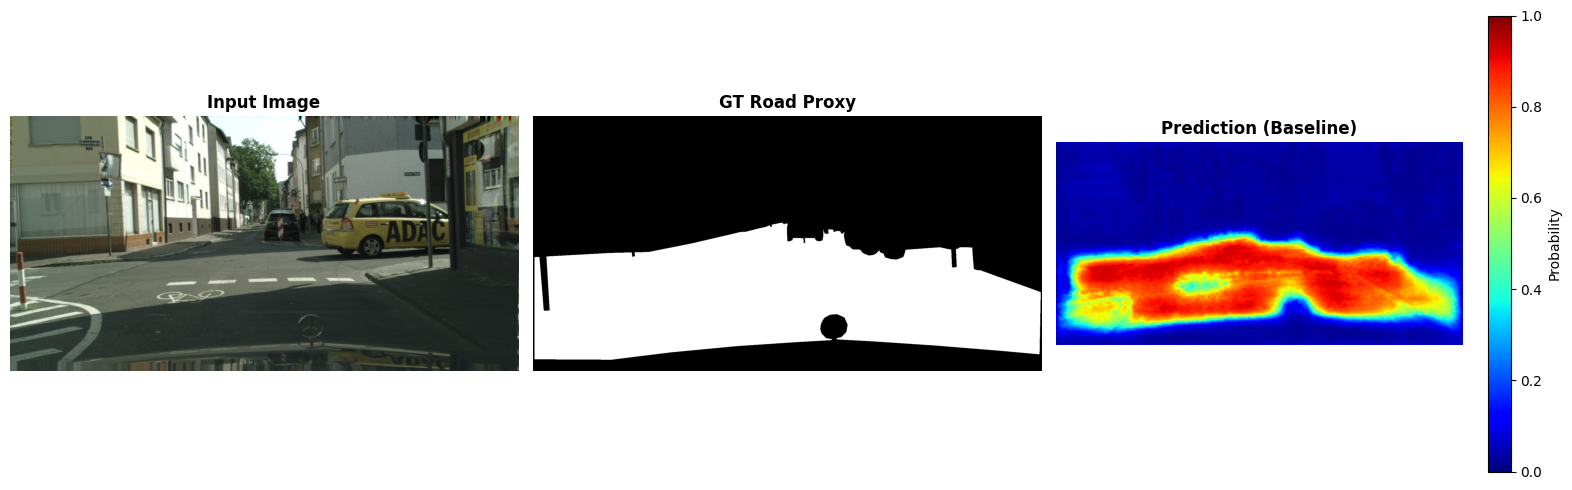

✅ 그림 저장 완료!
   경로: /content/drive/MyDrive/loid_cityscapes/experiments/figs/day1_baseline_result.png


In [ ]:
import os

# 폴더 자동 생성
os.makedirs(f"{PROJECT_ROOT}/experiments/figs", exist_ok=True)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. 원본 이미지
img_display = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
axes[0].imshow(img_display)
axes[0].set_title("Input Image", fontsize=12, fontweight='bold')
axes[0].axis('off')

# 2. GT
gt_display = gt_tensor.cpu().numpy()
axes[1].imshow(gt_display, cmap='gray', vmin=0, vmax=1)
axes[1].set_title("GT Road Proxy", fontsize=12, fontweight='bold')
axes[1].axis('off')

# 3. 예측
im = axes[2].imshow(prob_pred, cmap='jet', vmin=0, vmax=1)
axes[2].set_title("Prediction (Baseline)", fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], label='Probability')

plt.tight_layout()
plt.savefig(f"{PROJECT_ROOT}/experiments/figs/day1_baseline_result.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ 그림 저장 완료!")
print(f"   경로: {PROJECT_ROOT}/experiments/figs/day1_baseline_result.png")


In [ ]:
print("\n" + "="*60)
print("🎉 Day 1 COMPLETE!")
print("="*60)

print("\n✅ 체크리스트:")
print(f"  [✓] PyTorch 설치: {torch.__version__}")
print(f"  [✓] 패키지 임포트: 완료")
print(f"  [✓] Cityscapes 로드: {len(train_dataset)} train + {len(val_dataset)} val")
print(f"  [✓] 모델 정의: DeepLabV3+ (ResNet34)")
print(f"  [✓] 학습: 1 epoch 완료 (Avg Loss: {avg_loss:.4f})")
print(f"  [✓] seg_baseline() 함수: 완성 및 테스트")
print(f"  [✓] 시각화: 저장 완료")

print("\n📁 산출물:")
if os.path.exists(ckpt_path):
    print(f"  ✅ 모델: {ckpt_path}")
if os.path.exists(f"{PROJECT_ROOT}/experiments/figs/day1_baseline_result.png"):
    print(f"  ✅ 그림: {PROJECT_ROOT}/experiments/figs/day1_baseline_result.png")

print("\n🚀 다음 단계 (Day 2):")
print("  1️⃣ YOLOv8 Detector로 occlusion mask 생성")
print("  2️⃣ get_occlusion_mask() 함수 구현")
print("  3️⃣ 앞차/사람 감지 시각화")

print("\n✨ Day 1 성공! 다음 노트북: 02_detector_occlusion.ipynb")
print("="*60)



🎉 Day 1 COMPLETE!

✅ 체크리스트:
  [✓] PyTorch 설치: 2.9.0+cu126
  [✓] 패키지 임포트: 완료
  [✓] Cityscapes 로드: 2975 train + 500 val
  [✓] 모델 정의: DeepLabV3+ (ResNet34)
  [✓] 학습: 1 epoch 완료 (Avg Loss: 0.3319)
  [✓] seg_baseline() 함수: 완성 및 테스트
  [✓] 시각화: 저장 완료

📁 산출물:
  ✅ 모델: /content/drive/MyDrive/loid_cityscapes/experiments/ckpts/baseline_seg.pth
  ✅ 그림: /content/drive/MyDrive/loid_cityscapes/experiments/figs/day1_baseline_result.png

🚀 다음 단계 (Day 2):
  1️⃣ YOLOv8 Detector로 occlusion mask 생성
  2️⃣ get_occlusion_mask() 함수 구현
  3️⃣ 앞차/사람 감지 시각화

✨ Day 1 성공! 다음 노트북: 02_detector_occlusion.ipynb


In [ ]:
import os
import torch
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("="*60)
print("🔍 Day 1 결과 검증 시작!")
print("="*60)

PROJECT_ROOT = "/content/drive/MyDrive/loid_cityscapes"
DATA_ROOT = f"{PROJECT_ROOT}/datasets"

# 1. 폴더 구조 확인
print("\n📁 1. 폴더 구조")
folders_to_check = [
    f"{PROJECT_ROOT}/experiments/ckpts",
    f"{PROJECT_ROOT}/experiments/figs",
    f"{PROJECT_ROOT}/experiments/logs",
    DATA_ROOT
]

for folder in folders_to_check:
    exists = os.path.exists(folder)
    print(f"   {folder}: {'✅' if exists else '❌'}")

# 2. 데이터셋 확인
print("\n📊 2. 데이터셋 상태")
if 'train_dataset' in globals():
    print(f"   Train: {len(train_dataset)}장")
    print(f"   Val: {len(val_dataset)}장")
    print(f"   ✅ 데이터셋 로드 완료")
else:
    print("   ❌ 데이터셋 변수 없음 (재로드 필요)")

# 3. 모델 파일 확인
print("\n🤖 3. 모델 파일")
ckpt_path = f"{PROJECT_ROOT}/experiments/ckpts/baseline_seg.pth"
if os.path.exists(ckpt_path):
    size_mb = os.path.getsize(ckpt_path) / (1024*1024)
    print(f"   ✅ baseline_seg.pth ({size_mb:.1f}MB)")
else:
    print("   ❌ 모델 파일 없음")

# 4. 시각화 파일 확인
print("\n🖼️ 4. 시각화 결과")
fig_path = f"{PROJECT_ROOT}/experiments/figs/day1_baseline_result.png"
if os.path.exists(fig_path):
    print(f"   ✅ day1_baseline_result.png")
else:
    print("   ❌ 시각화 파일 없음")

# 5. seg_baseline 함수 테스트
print("\n🎯 5. seg_baseline() 테스트")
try:
    if 'val_dataset' in globals():
        val_sample = val_dataset[0]
        img_tensor = val_sample['image']

        prob_pred = seg_baseline(img_tensor, model, device=DEVICE)
        print(f"   ✅ 함수 동작 확인!")
        print(f"      입력 shape: {img_tensor.shape}")
        print(f"      출력 shape: {prob_pred.shape}")
        print(f"      출력 범위: [{prob_pred.min():.3f}, {prob_pred.max():.3f}]")
    else:
        print("   ❌ val_dataset 없음")
except Exception as e:
    print(f"   ❌ 함수 오류: {e}")

# 6. 최종 점수
print("\n📊 6. Day 1 완성도")
score = 0
total = 5

if os.path.exists(DATA_ROOT): score += 1
if 'train_dataset' in globals(): score += 1
if os.path.exists(ckpt_path): score += 1
if os.path.exists(fig_path): score += 1
if 'seg_baseline' in globals(): score += 1

print(f"   완성도: {score}/{total} ({score/total*100:.0f}%)")

if score == 5:
    print("\n🎉 Day 1 완벽 성공!")
    print("🚀 Day 2 준비 완료!")
else:
    print("\n⚠️ 아직 미완성 항목 있음. 위 체크리스트 확인하세요.")

print("="*60)


🔍 Day 1 결과 검증 시작!

📁 1. 폴더 구조
   /content/drive/MyDrive/loid_cityscapes/experiments/ckpts: ✅
   /content/drive/MyDrive/loid_cityscapes/experiments/figs: ✅
   /content/drive/MyDrive/loid_cityscapes/experiments/logs: ✅
   /content/drive/MyDrive/loid_cityscapes/datasets: ✅

📊 2. 데이터셋 상태
   Train: 2975장
   Val: 500장
   ✅ 데이터셋 로드 완료

🤖 3. 모델 파일
   ✅ baseline_seg.pth (85.8MB)

🖼️ 4. 시각화 결과
   ✅ day1_baseline_result.png

🎯 5. seg_baseline() 테스트
   ✅ 함수 동작 확인!
      입력 shape: torch.Size([3, 1024, 2048])
      출력 shape: (1024, 2048)
      출력 범위: [0.160, 0.666]

📊 6. Day 1 완성도
   완성도: 5/5 (100%)

🎉 Day 1 완벽 성공!
🚀 Day 2 준비 완료!


  ... processed 50 images
  ... processed 100 images
  ... processed 150 images
  ... processed 200 images
  ... processed 250 images
  ... processed 300 images
  ... processed 350 images
  ... processed 400 images
  ... processed 450 images
  ... processed 500 images

✅ Val Global Metrics
Images evaluated: 500
IoU (global):     0.4681
Precision:        0.9334
Recall:           0.4843
mIoU (per-image): 0.4545

💾 Saved per-image eval CSV: /content/drive/MyDrive/loid_cityscapes/experiments/logs/day1_val_eval.csv

----------------------------------------------------------------------
🚨 Top-10 FP-heavy cases
 idx     iou  precision   recall     tp       fp      fn  conf_pos_mean  conf_bg_mean                  case                                                                                                      img_path
 302 0.00000   0.000000 0.000000    0.0 767730.0     0.0       0.000000      0.425239  Severe FP (over-seg)   /content/drive/MyDrive/loid_cityscapes/datasets/leftImg8bit/

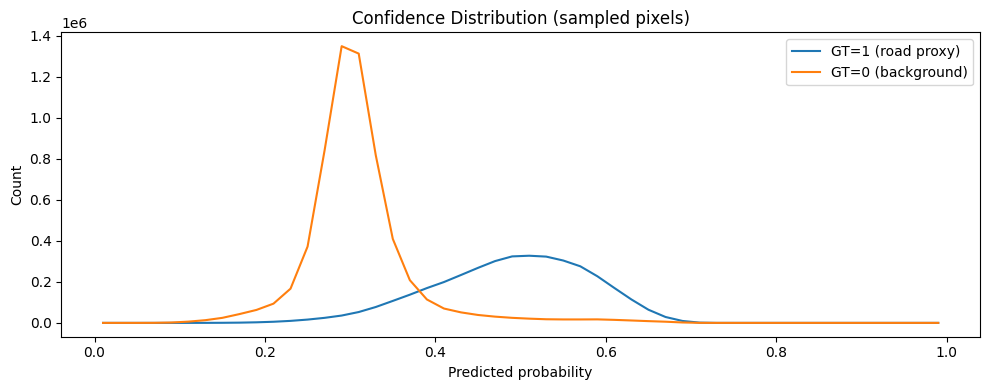

🖼️ Saved confidence hist: /content/drive/MyDrive/loid_cityscapes/experiments/figs/day1_confidence_hist.png

📌 Case distribution
case
Normal / Other                393
Severe FN (under-seg)          85
Severe FP (over-seg)           15
Low confidence on road          6
High background confidence      1

✅ Val evaluation done.


In [ ]:
import os, numpy as np, pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# =========================
# Eval 설정 (필요하면 여기만 조절)
# =========================
EVAL_BATCH_SIZE = 2          # GPU 메모리 부족하면 1로
EVAL_RESIZE = (512, 1024)    # 너 seg_baseline과 동일
THRESH = 0.5
MAX_VAL_IMAGES = None        # 전체면 None, 빠른 테스트면 예: 50
HIST_BINS = 50
SAMPLE_PER_IMAGE = 20000     # 신뢰도 분포 픽셀 샘플 수(속도 절충)
eps = 1e-7

os.makedirs(f"{PROJECT_ROOT}/experiments/logs", exist_ok=True)
os.makedirs(f"{PROJECT_ROOT}/experiments/figs", exist_ok=True)

@torch.no_grad()
def evaluate_val(model, val_dataset, device=DEVICE):
    model.eval()
    loader = DataLoader(
        val_dataset,
        batch_size=EVAL_BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=(device == "cuda")
    )

    # global confusion
    TP = FP = FN = TN = 0.0

    # per-image record
    records = []

    # confidence histogram (pos/neg)
    hist_pos = np.zeros(HIST_BINS, dtype=np.int64)
    hist_neg = np.zeros(HIST_BINS, dtype=np.int64)
    bin_edges = np.linspace(0, 1, HIST_BINS + 1)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    processed = 0

    for bidx, batch in enumerate(loader):
        images = batch["image"].to(device, non_blocking=True)    # [B,3,H,W]
        gts    = batch["lane_gt"].to(device, non_blocking=True)  # [B,H,W]
        paths  = batch["img_path"]                               # list[str]
        B, _, H, W = images.shape

        # resize -> forward
        x_small = F.interpolate(images, size=EVAL_RESIZE, mode="bilinear", align_corners=False)
        logits_small = model(x_small)  # [B,h,w] (너 모델이 squeeze(1)해서)
        probs_small = torch.sigmoid(logits_small)

        # upsample to orig for metric
        logits = F.interpolate(
            logits_small.unsqueeze(1), size=(H, W),
            mode="bilinear", align_corners=False
        ).squeeze(1)  # [B,H,W]
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).float()
        gt = (gts >= 0.5).float()

        # batch confusion
        TP += (preds * gt).sum().item()
        FP += (preds * (1 - gt)).sum().item()
        FN += ((1 - preds) * gt).sum().item()
        TN += ((1 - preds) * (1 - gt)).sum().item()

        # per-image stats + case classify
        pred_area = preds.sum(dim=(1,2))
        pos_area  = gt.sum(dim=(1,2))
        tp_i = (preds * gt).sum(dim=(1,2))
        fp_i = (preds * (1-gt)).sum(dim=(1,2))
        fn_i = ((1-preds) * gt).sum(dim=(1,2))

        iou_i = tp_i / (tp_i + fp_i + fn_i + eps)
        prec_i = tp_i / (tp_i + fp_i + eps)
        rec_i  = tp_i / (tp_i + fn_i + eps)

        conf_pos = (probs * gt).sum(dim=(1,2)) / (pos_area + eps)
        conf_bg  = (probs * (1-gt)).sum(dim=(1,2)) / ((1-gt).sum(dim=(1,2)) + eps)

        for i in range(B):
            iou = float(iou_i[i].item())
            fp_pix = float(fp_i[i].item())
            fn_pix = float(fn_i[i].item())
            tp_pix = float(tp_i[i].item())

            fp_ratio = fp_pix / (float(pred_area[i].item()) + eps)
            fn_ratio = fn_pix / (float(pos_area[i].item()) + eps)
            cpos = float(conf_pos[i].item())
            cbg  = float(conf_bg[i].item())

            if iou < 0.30 and fn_ratio > 0.60:
                case = "Severe FN (under-seg)"
            elif iou < 0.30 and fp_ratio > 0.60:
                case = "Severe FP (over-seg)"
            elif cpos < 0.45:
                case = "Low confidence on road"
            elif cbg > 0.35:
                case = "High background confidence"
            else:
                case = "Normal / Other"

            records.append({
                "idx": processed + i,
                "img_path": paths[i],
                "iou": iou,
                "precision": float(prec_i[i].item()),
                "recall": float(rec_i[i].item()),
                "tp": tp_pix, "fp": fp_pix, "fn": fn_pix,
                "conf_pos_mean": cpos,
                "conf_bg_mean": cbg,
                "case": case
            })

        # confidence hist (샘플링, 속도 절충)
        gt_small = F.interpolate(gt.unsqueeze(1), size=EVAL_RESIZE, mode="nearest").squeeze(1)  # [B,h,w]
        for i in range(B):
            p = probs_small[i].flatten()
            g = gt_small[i].flatten()
            N = p.numel()
            sN = min(SAMPLE_PER_IMAGE, N)
            ridx = torch.randint(0, N, (sN,), device=device)
            p_s = p[ridx]
            g_s = g[ridx] >= 0.5

            if g_s.any():
                hist_pos += torch.histc(p_s[g_s], bins=HIST_BINS, min=0.0, max=1.0).cpu().numpy().astype(np.int64)
            if (~g_s).any():
                hist_neg += torch.histc(p_s[~g_s], bins=HIST_BINS, min=0.0, max=1.0).cpu().numpy().astype(np.int64)

        processed += B
        if MAX_VAL_IMAGES is not None and processed >= MAX_VAL_IMAGES:
            break

        if processed % 50 == 0:
            print(f"  ... processed {processed} images")

    # global metrics
    iou_global = TP / (TP + FP + FN + eps)
    precision_global = TP / (TP + FP + eps)
    recall_global = TP / (TP + FN + eps)

    df = pd.DataFrame(records)

    print("\n" + "="*70)
    print("✅ Val Global Metrics")
    print("="*70)
    print(f"Images evaluated: {len(df)}")
    print(f"IoU (global):     {iou_global:.4f}")
    print(f"Precision:        {precision_global:.4f}")
    print(f"Recall:           {recall_global:.4f}")
    print(f"mIoU (per-image): {df['iou'].mean():.4f}")

    # save csv
    csv_path = f"{PROJECT_ROOT}/experiments/logs/day1_val_eval.csv"
    df.to_csv(csv_path, index=False)
    print(f"\n💾 Saved per-image eval CSV: {csv_path}")

    # FP/FN Top-10
    def show_top(df_, key, k=10, title=""):
        cols = ["idx","iou","precision","recall","tp","fp","fn","conf_pos_mean","conf_bg_mean","case","img_path"]
        print("\n" + "-"*70)
        print(title)
        print(df_.sort_values(key, ascending=False).head(k)[cols].to_string(index=False))

    show_top(df, "fp", 10, "🚨 Top-10 FP-heavy cases")
    show_top(df, "fn", 10, "🚨 Top-10 FN-heavy cases")
    show_top(df.assign(bad=1-df["iou"]), "bad", 10, "🚨 Top-10 Lowest IoU cases")

    # confidence hist plot
    fig_path = f"{PROJECT_ROOT}/experiments/figs/day1_confidence_hist.png"
    plt.figure(figsize=(10,4))
    plt.plot(centers, hist_pos, label="GT=1 (road proxy)")
    plt.plot(centers, hist_neg, label="GT=0 (background)")
    plt.title("Confidence Distribution (sampled pixels)")
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"🖼️ Saved confidence hist: {fig_path}")

    # case distribution
    print("\n" + "="*70)
    print("📌 Case distribution")
    print("="*70)
    print(df["case"].value_counts().to_string())

    return df

# 실행
df_eval = evaluate_val(model, val_dataset, device=DEVICE)
print("\n✅ Val evaluation done.")


In [ ]:
from ultralytics import YOLO

yolo = YOLO("yolov8m.pt")  # 원하는 weight 쓰면 여기만 바꾸면 됨
names = yolo.model.names

print(f"✅ #classes: {len(names)}")
for i in sorted(names.keys()):
    print(f"{i:>3}: {names[i]}")


✅ #classes: 80
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
 10: fire hydrant
 11: stop sign
 12: parking meter
 13: bench
 14: bird
 15: cat
 16: dog
 17: horse
 18: sheep
 19: cow
 20: elephant
 21: bear
 22: zebra
 23: giraffe
 24: backpack
 25: umbrella
 26: handbag
 27: tie
 28: suitcase
 29: frisbee
 30: skis
 31: snowboard
 32: sports ball
 33: kite
 34: baseball bat
 35: baseball glove
 36: skateboard
 37: surfboard
 38: tennis racket
 39: bottle
 40: wine glass
 41: cup
 42: fork
 43: knife
 44: spoon
 45: bowl
 46: banana
 47: apple
 48: sandwich
 49: orange
 50: broccoli
 51: carrot
 52: hot dog
 53: pizza
 54: donut
 55: cake
 56: chair
 57: couch
 58: potted plant
 59: bed
 60: dining table
 61: toilet
 62: tv
 63: laptop
 64: mouse
 65: remote
 66: keyboard
 67: cell phone
 68: microwave
 69: oven
 70: toaster
 71: sink
 72: refrigerator
 73: book
 74: clock
 75: vase
 76: scissors
 77: teddy b

In [ ]:
import time, os, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# =========================
# Speed Benchmark Config
# =========================
BENCH_N_IMAGES = 200      # 측정할 이미지 수 (None이면 val 전체)
BENCH_BATCH = 1           # 1이면 "이미지당" 시간 가장 직관적 (GPU 여유면 2~8 가능)
WARMUP_ITERS = 10         # 워밍업(초기 CUDA/cudnn 튜닝 제외)
RESIZE_TO = (512, 1024)   # 너 seg_baseline과 동일
USE_AMP = False           # True면 fp16 자동혼합정밀(속도↑, 수치 약간 변화 가능)

# cudnn autotune (입력 크기가 고정일 때 속도 ↑)
torch.backends.cudnn.benchmark = True

def _sync(device):
    if device == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def benchmark_seg_inference(model, dataset, device=DEVICE,
                            n_images=200, batch_size=1,
                            resize_to=(512,1024),
                            warmup_iters=10, use_amp=False):
    model.eval()

    # subset 처리
    if n_images is None:
        n_images = len(dataset)
    n_images = min(n_images, len(dataset))

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=(device=="cuda")
    )

    times_ms = []
    seen = 0

    # 워밍업: 첫 몇 iteration은 측정 제외
    warm_left = warmup_iters

    for batch in loader:
        images = batch["image"].to(device, non_blocking=True)  # [B,3,H,W]

        # ---- timing start ----
        _sync(device)
        t0 = time.perf_counter()

        # resize + forward (추론 파이프라인과 동일하게 포함)
        x_small = F.interpolate(images, size=resize_to, mode="bilinear", align_corners=False)

        if use_amp and device == "cuda":
            with torch.cuda.amp.autocast():
                logits_small = model(x_small)  # [B,h,w]
        else:
            logits_small = model(x_small)

        # 필요하면 sigmoid까지 포함(실제 사용 기준)
        _ = torch.sigmoid(logits_small)

        _sync(device)
        t1 = time.perf_counter()
        # ---- timing end ----

        elapsed_ms = (t1 - t0) * 1000.0

        # 워밍업 제외
        if warm_left > 0:
            warm_left -= 1
        else:
            # "이미지당" 평균 ms로 기록
            bsz = images.shape[0]
            times_ms.append(elapsed_ms / bsz)

        seen += images.shape[0]
        if seen >= n_images:
            break

    times_ms = np.array(times_ms, dtype=np.float32)
    if len(times_ms) == 0:
        print("⚠️ 측정된 샘플이 없습니다. WARMUP_ITERS를 줄이거나 BENCH_N_IMAGES를 늘려보세요.")
        return

    mean_ms = float(times_ms.mean())
    med_ms  = float(np.median(times_ms))
    p90_ms  = float(np.percentile(times_ms, 90))
    p95_ms  = float(np.percentile(times_ms, 95))
    fps = 1000.0 / mean_ms

    print("="*70)
    print("⏱️ Segmentation Inference Speed (per-image)")
    print("="*70)
    print(f"Device:        {device}")
    print(f"AMP:           {use_amp}")
    print(f"Resize to:     {resize_to}")
    print(f"Batch size:    {batch_size}  (reported as per-image ms)")
    print(f"Measured imgs: {len(times_ms)}  (warmup 제외)")
    print("-"*70)
    print(f"Mean:   {mean_ms:.2f} ms/image   -> {fps:.2f} FPS")
    print(f"Median: {med_ms:.2f} ms/image")
    print(f"P90:    {p90_ms:.2f} ms/image")
    print(f"P95:    {p95_ms:.2f} ms/image")
    print("="*70)

    # (선택) 로그 저장
    save_path = f"{PROJECT_ROOT}/experiments/logs/day1_infer_speed_ms.npy"
    np.save(save_path, times_ms)
    print(f"💾 Saved raw per-image times: {save_path}")

# 실행
benchmark_seg_inference(
    model=model,
    dataset=val_dataset,
    device=DEVICE,
    n_images=BENCH_N_IMAGES,
    batch_size=BENCH_BATCH,
    resize_to=RESIZE_TO,
    warmup_iters=WARMUP_ITERS,
    use_amp=USE_AMP
)


⏱️ Segmentation Inference Speed (per-image)
Device:        cuda
AMP:           False
Resize to:     (512, 1024)
Batch size:    1  (reported as per-image ms)
Measured imgs: 190  (warmup 제외)
----------------------------------------------------------------------
Mean:   42.09 ms/image   -> 23.76 FPS
Median: 39.69 ms/image
P90:    51.24 ms/image
P95:    54.84 ms/image
💾 Saved raw per-image times: /content/drive/MyDrive/loid_cityscapes/experiments/logs/day1_infer_speed_ms.npy


📦 Reload dataset pairs & analyze GT distribution
✅ Train pairs: 2975
✅ Val pairs:   500

🔎 Scanning Train...
  [train] processed 200/2975
  [train] processed 400/2975
  [train] processed 600/2975
  [train] processed 800/2975
  [train] processed 1000/2975
  [train] processed 1200/2975
  [train] processed 1400/2975
  [train] processed 1600/2975
  [train] processed 1800/2975
  [train] processed 2000/2975
  [train] processed 2200/2975
  [train] processed 2400/2975
  [train] processed 2600/2975
  [train] processed 2800/2975

🔎 Scanning Val...
  [val] processed 200/500
  [val] processed 400/500

📊 Split Summary
split  num_images  img_h_mean  img_w_mean  road_ratio_mean  road_ratio_median  road_ratio_min  road_ratio_max  bg_ratio_mean
train        2975      1024.0      2048.0         0.388332           0.401280             0.0        0.548405       0.611668
  val         500      1024.0      2048.0         0.381110           0.396988             0.0        0.495692       0.618890


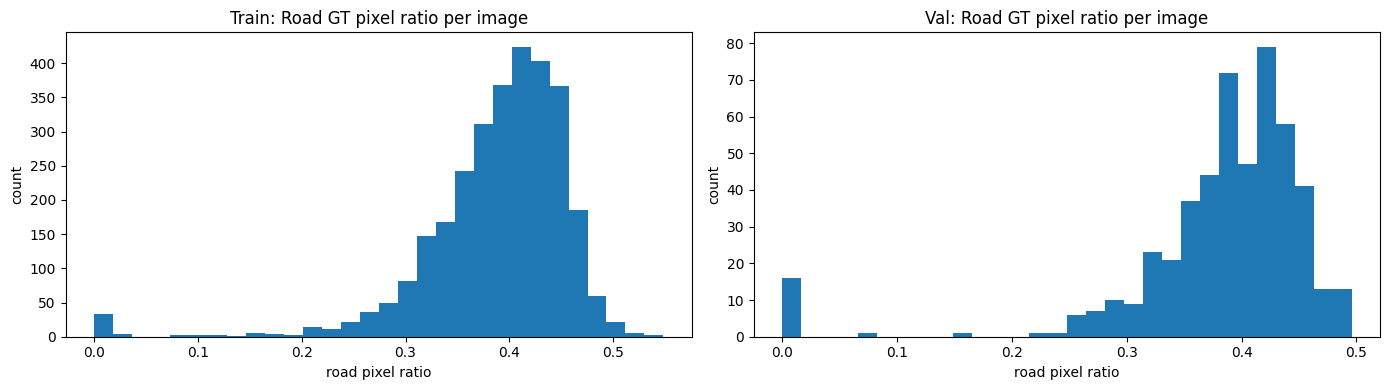

🖼️ Saved histogram: /content/drive/MyDrive/loid_cityscapes/experiments/figs/gt_road_ratio_hist.png

----------------------------------------------------------------------
⚖️ Class imbalance report (train)
----------------------------------------------------------------------
Mean road ratio: 0.3883
Mean bg ratio:   0.6117
BG / Road:       1.58x (배경 픽셀이 도로보다 몇 배 많은지)
road<5% images:  37 / 2975
road>50% images: 22 / 2975

----------------------------------------------------------------------
⚖️ Class imbalance report (val)
----------------------------------------------------------------------
Mean road ratio: 0.3811
Mean bg ratio:   0.6189
BG / Road:       1.62x (배경 픽셀이 도로보다 몇 배 많은지)
road<5% images:  16 / 500
road>50% images: 0 / 500

💾 Saved split stats CSV: /content/drive/MyDrive/loid_cityscapes/experiments/logs/gt_road_ratio_stats.csv


In [ ]:
import os, glob, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
DATA_ROOT = f"{PROJECT_ROOT}/datasets"   # 이미 쓰던 경로
CITYSCAPES_ROAD_IDS = {7, 8, 9, 10}      # road/sidewalk/parking/rail track
N_SAMPLES = None                         # None이면 전부 스캔, 빠르게는 예: 300
HIST_BINS = 30

def get_pairs(data_root, split):
    img_dir = os.path.join(data_root, "leftImg8bit", split)
    gt_dir  = os.path.join(data_root, "gtFine", split)

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*", "*_leftImg8bit.png")))
    pairs = []
    for ip in img_paths:
        city = os.path.basename(os.path.dirname(ip))
        gt_name = os.path.basename(ip).replace("_leftImg8bit.png", "_gtFine_labelIds.png")
        gp = os.path.join(gt_dir, city, gt_name)
        if os.path.exists(gp):
            pairs.append((ip, gp))
    return pairs

def analyze_split(pairs, split_name, n_samples=None, road_ids=CITYSCAPES_ROAD_IDS):
    if n_samples is not None:
        pairs = pairs[:min(n_samples, len(pairs))]

    road_ratios = []
    bg_ratios = []
    h_list, w_list = [], []

    # (선택) 라벨ID 전체 분포도 같이 보고 싶으면 아래 사용
    # label_hist = np.zeros(256, dtype=np.int64)

    for i, (ip, gp) in enumerate(pairs):
        lab = np.asarray(Image.open(gp), dtype=np.uint8)  # [H,W] labelIds
        H, W = lab.shape
        h_list.append(H); w_list.append(W)

        road = np.isin(lab, list(road_ids))
        road_ratio = road.mean()
        road_ratios.append(road_ratio)
        bg_ratios.append(1.0 - road_ratio)

        # label_hist += np.bincount(lab.flatten(), minlength=256)

        if (i+1) % 200 == 0:
            print(f"  [{split_name}] processed {i+1}/{len(pairs)}")

    road_ratios = np.array(road_ratios, dtype=np.float32)
    bg_ratios   = np.array(bg_ratios, dtype=np.float32)

    stats = {
        "split": split_name,
        "num_images": len(pairs),
        "img_h_mean": float(np.mean(h_list)) if h_list else None,
        "img_w_mean": float(np.mean(w_list)) if w_list else None,
        "road_ratio_mean": float(road_ratios.mean()) if len(road_ratios) else None,
        "road_ratio_median": float(np.median(road_ratios)) if len(road_ratios) else None,
        "road_ratio_min": float(road_ratios.min()) if len(road_ratios) else None,
        "road_ratio_max": float(road_ratios.max()) if len(road_ratios) else None,
        "bg_ratio_mean": float(bg_ratios.mean()) if len(bg_ratios) else None
    }

    return stats, road_ratios

# =========================
# 1) Dataset reload (file pairs)
# =========================
print("="*70)
print("📦 Reload dataset pairs & analyze GT distribution")
print("="*70)

train_pairs = get_pairs(DATA_ROOT, "train")
val_pairs   = get_pairs(DATA_ROOT, "val")

print(f"✅ Train pairs: {len(train_pairs)}")
print(f"✅ Val pairs:   {len(val_pairs)}")

if len(train_pairs) == 0 or len(val_pairs) == 0:
    print("❌ pairs를 못 찾았어. DATA_ROOT 폴더 구조/경로를 확인해줘.")
else:
    # =========================
    # 2) Stats
    # =========================
    print("\n🔎 Scanning Train...")
    train_stats, train_road_ratios = analyze_split(train_pairs, "train", n_samples=N_SAMPLES)

    print("\n🔎 Scanning Val...")
    val_stats, val_road_ratios = analyze_split(val_pairs, "val", n_samples=N_SAMPLES)

    df_stats = pd.DataFrame([train_stats, val_stats])
    print("\n" + "="*70)
    print("📊 Split Summary")
    print("="*70)
    print(df_stats.to_string(index=False))

    # =========================
    # 3) Road GT distribution (histogram)
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].hist(train_road_ratios, bins=HIST_BINS)
    axes[0].set_title("Train: Road GT pixel ratio per image")
    axes[0].set_xlabel("road pixel ratio")
    axes[0].set_ylabel("count")

    axes[1].hist(val_road_ratios, bins=HIST_BINS)
    axes[1].set_title("Val: Road GT pixel ratio per image")
    axes[1].set_xlabel("road pixel ratio")
    axes[1].set_ylabel("count")

    plt.tight_layout()
    save_path = f"{PROJECT_ROOT}/experiments/figs/gt_road_ratio_hist.png"
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"🖼️ Saved histogram: {save_path}")

    # =========================
    # 4) Class imbalance (road vs background)
    # =========================
    def imbalance_report(road_ratios, split_name):
        road_mean = float(np.mean(road_ratios))
        bg_mean = 1.0 - road_mean
        # 배경:도로 비율 (예: 2.5면 배경이 2.5배 많음)
        bg_over_road = bg_mean / (road_mean + 1e-7)
        print("\n" + "-"*70)
        print(f"⚖️ Class imbalance report ({split_name})")
        print("-"*70)
        print(f"Mean road ratio: {road_mean:.4f}")
        print(f"Mean bg ratio:   {bg_mean:.4f}")
        print(f"BG / Road:       {bg_over_road:.2f}x (배경 픽셀이 도로보다 몇 배 많은지)")

        # “도로가 거의 없는”/“도로가 매우 많은” 이미지 카운트도 같이
        low = (road_ratios < 0.05).sum()
        high = (road_ratios > 0.50).sum()
        print(f"road<5% images:  {int(low)} / {len(road_ratios)}")
        print(f"road>50% images: {int(high)} / {len(road_ratios)}")

    imbalance_report(train_road_ratios, "train")
    imbalance_report(val_road_ratios, "val")

    # (선택) 저장
    csv_path = f"{PROJECT_ROOT}/experiments/logs/gt_road_ratio_stats.csv"
    df_stats.to_csv(csv_path, index=False)
    print(f"\n💾 Saved split stats CSV: {csv_path}")
